In [26]:
import cv2 # pip3 install opencv-python
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt

In [42]:
train_dir = '../data/train/'
test_dir = '../data/test/'
img_size = 50
lr = 1e-3

In [43]:
# one hot encoding
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [44]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(train_dir)):
        if (not img.endswith('.jpg')):
            continue
        label = label_img(img)
        path = os.path.join(train_dir, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # greyscale
        img = cv2.resize(img, (img_size, img_size) )  # unite the figure size
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    return training_data

In [45]:
train_data = create_train_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:27<00:00, 908.76it/s]


In [46]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(test_dir)):
        if (not img.endswith('.jpg')):
            continue
        path = os.path.join(test_dir,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        testing_data.append([np.array(img), img_num]) # no label
        
    shuffle(testing_data)
    return testing_data


In [47]:
test_data = process_test_data()

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:13<00:00, 924.47it/s]


In [48]:
import tflearn # need to install tensorflow first
from tflearn.layers.conv import conv_2d, max_pool_2d  # 2d_CNN and max pooling
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression # cross entropy

In [49]:
import tensorflow as tf
tf.reset_default_graph() # need to reset the default graph for multiple running

In [50]:
convnet = input_data(shape = [None, img_size, img_size, 1], name = 'input')

In [51]:
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

In [52]:
convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate = lr, loss='categorical_crossentropy', name='targets')

In [53]:
model = tflearn.DNN(convnet, tensorboard_dir='log')
train = train_data[:-500]
test = train_data[-500:]

In [54]:
X = np.array([i[0] for i in train], dtype=np.float64).reshape(-1, img_size, img_size, 1)
y = np.array([i[1] for i in train], dtype=np.float64)
Xtest = np.array([i[0] for i in test], dtype=np.float64).reshape(-1, img_size, img_size, 1)
ytest = np.array([i[1] for i in test], dtype=np.float64)

In [55]:
model.fit({'input': X}, {'targets': y}, n_epoch=3, validation_set=({'input': Xtest}, {'targets': ytest}), snapshot_step=500, show_metric=True, run_id='model' )

Training Step: 1148  | total loss: 0.69365 | time: 114.255s
| Adam | epoch: 003 | loss: 0.69365 - acc: 0.4884 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.69372 | time: 115.535s
| Adam | epoch: 003 | loss: 0.69372 - acc: 0.4864 | val_loss: 0.69337 - val_acc: 0.4740 -- iter: 24500/24500
--


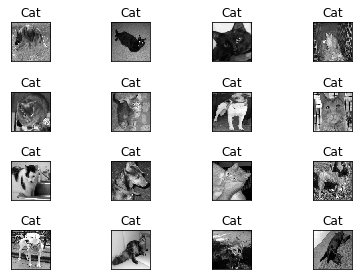

In [56]:
fig = plt.figure()
for num,data in enumerate(test_data[:16]):
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(img_size, img_size, 1)
    model_out = model.predict([data])[0]
    if np.argmax(model_out) == 1: 
        label = 'Dog'
    else: 
        label = 'Cat'
    y.imshow(orig, cmap='gray')
    plt.title(label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.show()